In [1]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
from tensorflow.keras import initializers
from tensorflow.keras.utils import plot_model

In [2]:
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=[800, 800, 3]))
vgg.trainable = False

In [4]:
# Using just tensorflow to create generic data of ...
# image
image = tf.zeros([1,800,800,3], tf.float32)
# bbox
bbox = tf.constant([[20, 30, 400, 500], [300, 400, 500, 600]])
# labels for each bbox
labels = tf.constant([6,8]) 
sub_sample = 16

im = image
fe_layers = vgg.layers
l_c = 0
req_layers = []
print("size of vgg feature layers: ", len(fe_layers))
# Use CPU to test the convolutions
with tf.device('CPU:0'):
    for i in fe_layers:
        im = i(im)
        if im.shape[1] < 800//16:
            print('brake')
            break
        req_layers.append(i)
        l_c += 1
        out_channels = im.shape
print('shape of ouput: ', out_channels)
print('number of layers needed: ', l_c)

size of vgg feature layers:  19
brake
shape of ouput:  (1, 50, 50, 512)
number of layers needed:  18


In [5]:
# create the bakcbone for fast r-cnn
input_fe = layers.Input(shape=[800, 800, 3])
fe_extractor = req_layers[1](input_fe)
for l in range(2,len(req_layers)):
    fe_extractor = req_layers[l](fe_extractor)

In [6]:
mid_channels = 512
in_channels = 512
n_anchor = 9

In [7]:
# 1) Intermediate Layer to reduce the dimentionallity
conv1 = layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), padding='same', activation='relu')

# 2) Regression layer are with the activation function which output is 0 to 1 remembering the ouput is 
# normalized
reg_layer = layers.Conv2D(filters=(n_anchor * 4), kernel_size=1, strides=(1, 1), activation='sigmoid', 
                          kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                         bias_initializer=initializers.Zeros())

# 3) Objectness classification layer use softmax layer to describe if there is a proposal for object or not
cls_layer = layers.Conv2D(filters=(n_anchor * 2), kernel_size=1, strides=(1, 1), activation='softmax',
                         kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                         bias_initializer=initializers.Zeros())

In [8]:
x = conv1(fe_extractor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

In [9]:
model = Model(inputs=input_fe, outputs=[pred_anchor_locs, pred_cls_scores])

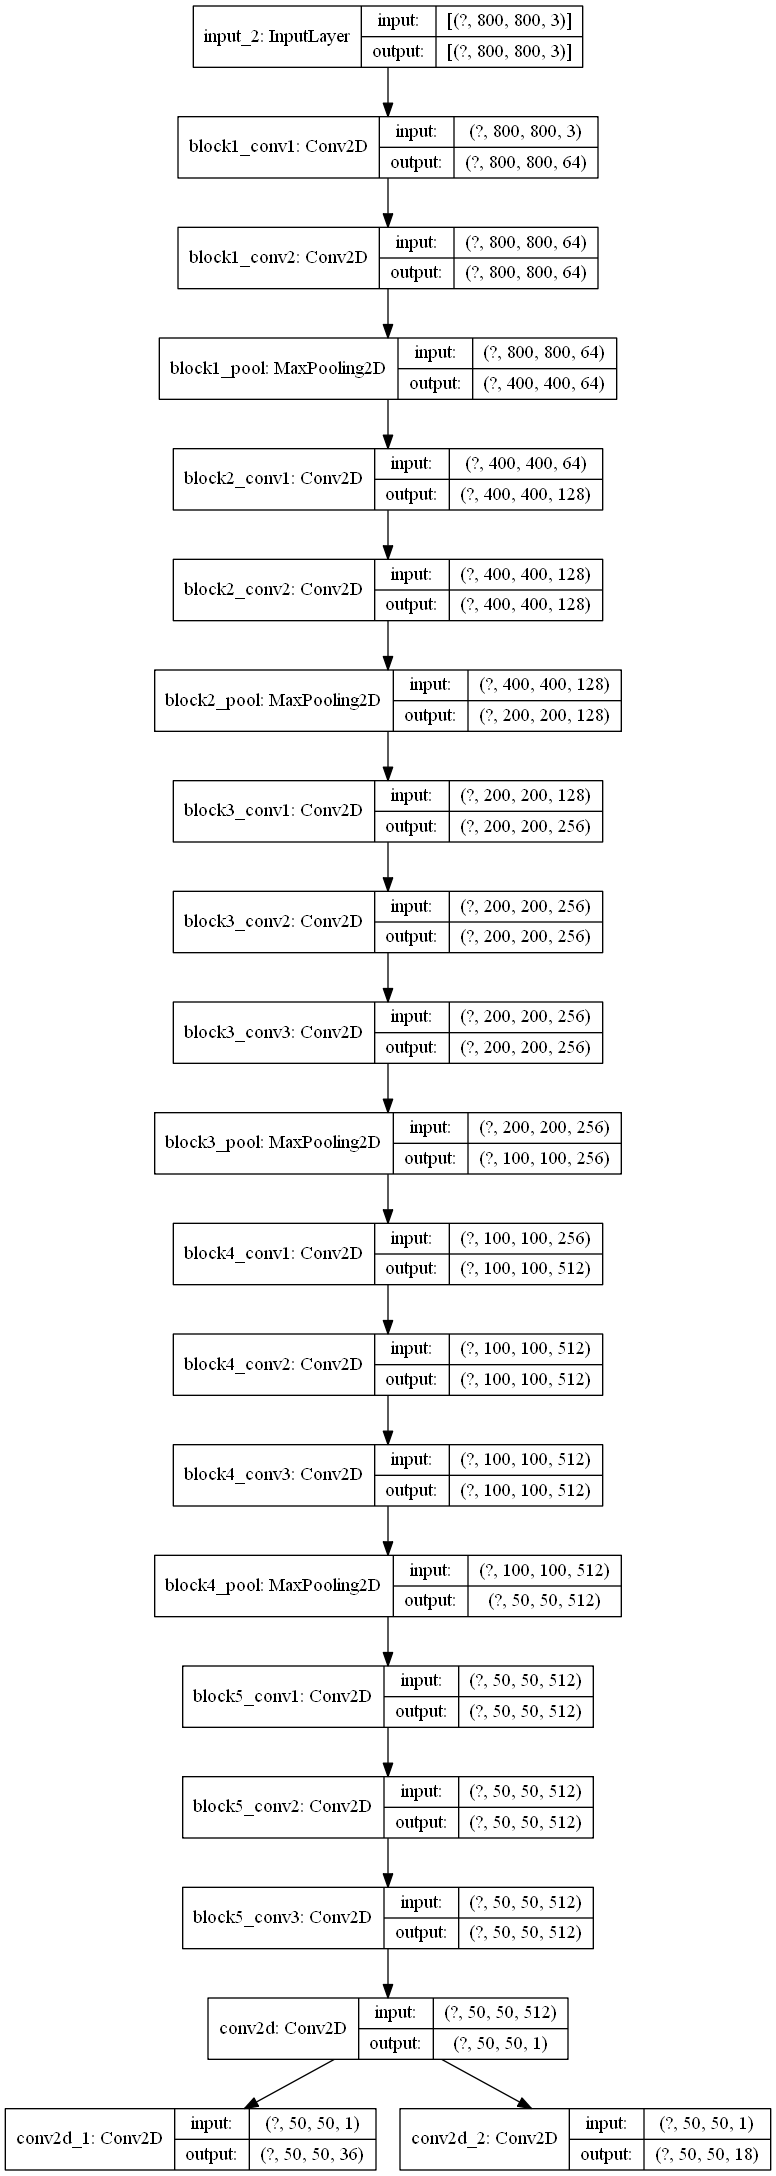

In [10]:
plot_model(model, show_shapes=True)

In [13]:
N_CLASSES = 1
fast_input = layers.Input(shape=[128, 25088])
x = layers.Dense(units=4096, activation='relu')(fast_input)
x = layers.Dense(units=4096, activation='relu')(x)
roi_cls_loc = layers.Dense(units=((N_CLASSES+1)*4), activation='relu', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                         bias_initializer=initializers.Zeros())(x)
roi_cls_score =layers.Dense(units=(N_CLASSES+1), activation='softmax')(x)

In [15]:
modelfast = Model(inputs=fast_input, outputs=[roi_cls_loc, roi_cls_score])

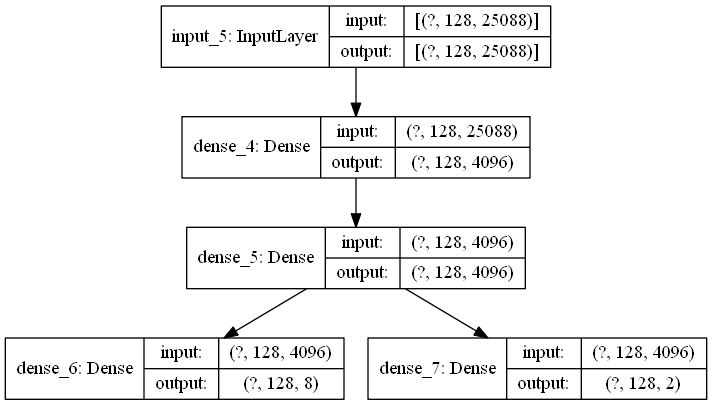

In [16]:
plot_model(modelfast, show_shapes=True)